In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
from matplotlib.ticker import FuncFormatter
import pyproj

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [3]:
def load_world_shapefile(file_path, crs_epsg=3857):
    world = gpd.read_file(file_path)
    return world.to_crs(epsg=crs_epsg)

In [4]:
def clean_data(df):
    df_clean = df.dropna().copy()
    return df_clean

In [5]:
def get_top_cities(df, n=15):
    top_cities = df.sort_values('Weight', ascending=False).head(n).copy()
    return top_cities

In [6]:
# Convert city DataFrame to GeoDataFrame and reproject to Web Mercator
def to_webmerc_gdf(df):
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
        crs="EPSG:4326"
    )
    return gdf.to_crs(epsg=3857)

In [7]:
# Plot France and neighboring countries
def plot_france_and_neighbors(ax, world, 
                             france_color="#F5DD27",
                             neighbor_color='#FAED8F',
                             water_color="#6fa8dc"):
    neighbor_list = [
        'Belgium', 'Luxembourg', 'Germany', 'Switzerland', 'Italy', 'Andorra',
        'Spain', 'Monaco', 'United Kingdom', 'Netherlands', 'Austria', 'Liechtenstein'
    ]
    ax.set_facecolor(water_color)
    neighbors = world[world['ADMIN'].isin(neighbor_list)]
    neighbors.plot(ax=ax, color=neighbor_color, edgecolor='gray', linewidth=0.7, zorder=1)
    france = world[world['ADMIN'] == 'France']
    france.plot(ax=ax, color=france_color, edgecolor='black', linewidth=1.7, zorder=2)

In [8]:
# Plot weighted KDE (density heatmap)
def plot_weighted_kde(gdf, ax, cmap="Greens", alpha=0.55, bw_adjust=0.4, levels=40):
    sns.kdeplot(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        weights=gdf["Weight"],
        ax=ax,
        cmap=cmap,
        fill=True,
        alpha=alpha,
        bw_adjust=bw_adjust,
        zorder=3,
        levels=levels,
        thresh=0.6
    )

In [9]:
# Plot city points
def plot_cities(gdf, ax, color="black"):
    ax.scatter(
        gdf.geometry.x,
        gdf.geometry.y,
        s=gdf["Weight"] * 4,
        color=color,
        alpha=0.7,
        edgecolor='white',
        linewidth=0.4,
        zorder=4
    )

In [10]:
# Annotate top cities
def annotate_top_cities(gdf_top, ax):
    for _, row in gdf_top.iterrows():
        ax.text(
            row.geometry.x, row.geometry.y, row["City"],
            fontsize=10, fontweight='bold', color='black',
            ha='left', va='bottom', zorder=5,
            bbox=dict(facecolor='white', alpha=0.65, edgecolor='none', pad=0.2)
        )

In [11]:
# Add north arrow
def add_north_arrow(ax, x=0.94, y=0.87, size=0.055, color='black'):
    trans = ax.transAxes
    arrow = patches.FancyArrow(
        x, y, 0, size,
        width=size/3,
        head_width=size*0.7,
        head_length=size*1.2,
        length_includes_head=True,
        color=color,
        transform=trans,
        zorder=8
    )
    arrow = ax.add_patch(arrow)
    # "N" letter
    ax.text(
        x, y + size*1.25, "N",
        transform=trans,
        ha="center", va="bottom",
        fontsize=13, fontweight='bold',
        color=color,
        zorder=9
    )
    arrow.set_zorder(30)

In [12]:
# Add Scale bar
def add_scale_bar(ax, length_km=10, location=(0.034, 0.09), height=9000):
    length_m = length_km * 1000  

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_start = xlim[0] + (xlim[1] - xlim[0]) * location[0]
    y_start = ylim[0] + (ylim[1] - ylim[0]) * location[1]

    # Black rectangle (left half)
    rect1 = patches.Rectangle(
        (x_start, y_start), length_m / 2, height,
        edgecolor='black', facecolor='black', zorder=10
    )
    scale = ax.add_patch(rect1)

    # Gray rectangle (right half)
    rect2 = patches.Rectangle(
        (x_start + length_m / 2, y_start), length_m / 2, height,
        edgecolor='black', facecolor='lightgray', zorder=10
    )
    ax.add_patch(rect2)

    # Text label
    ax.text(
        x_start + length_m / 2, y_start + height * 1.35,
        f"{length_km} km",
        fontsize=10, ha='center', fontweight='bold', color='black', zorder=11
    )
    scale.set_zorder(30)

In [13]:
# Add City legend
def add_city_legend(ax, weights, min_size=20, max_size=80, color='black', alpha=0.7, label_template="{w} visits", loc=(0.1, 0.17)):
    legend_weights = [int(np.min(weights)), int(np.max(weights))]
    # Marker sizes must be consistent with plot_cities!
    scaled_sizes = ((np.array(legend_weights) - np.min(weights)) / (np.max(weights) - np.min(weights))) * (max_size - min_size) + min_size
    legend_elements = [
        Line2D(
            [0], [0], marker='o', color='none',
            label=label_template.format(w=w),
            markerfacecolor=color, markersize=np.sqrt(s), alpha=alpha
        )
        for w, s in zip(legend_weights, scaled_sizes)
    ]
    # Place legend
    leg = ax.legend(
        handles=legend_elements,
        title="City visits",
        loc='center',
        bbox_to_anchor=loc,
        frameon=True,
        framealpha=0.8,
        fontsize=9,
        title_fontsize=10,
        borderpad=0.8,
    )
    leg.set_zorder(30)

In [14]:
# Add text
def add_datasource_text(fig, text=None, x=0.125, y=0.132, fontsize=7):
    if text is None:
        text = (
            "Datasource:\n"
            "https://github.com/thomascamminady/LeTourDataSet\n"
            "https://en.wikipedia.org/wiki/2025_Tour_de_France\n"
            "\n"
            "©️ Created by: Tamas Rozsahegyi"
        )
    fig.text(
        x, y,
        text,
        fontsize=fontsize,
        va='bottom',
        color='gray',
        bbox=dict(
            facecolor='white',
            alpha=0.6,
            edgecolor='none'
        )
    )

In [15]:
# Add sticks
def set_latlon_ticks(ax):
    # Projection transformation: Web Mercator → WGS84 (EPSG:4326)
    proj = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

    def format_lon(x, pos=None):
        lon, _ = proj.transform(x, ax.get_ylim()[0])
        return f"{lon:.0f}°E"

    def format_lat(y, pos=None):
        _, lat = proj.transform(ax.get_xlim()[0], y)
        return f"{lat:.0f}°N"

    ax.xaxis.set_major_formatter(FuncFormatter(format_lon))
    ax.yaxis.set_major_formatter(FuncFormatter(format_lat))
    ax.tick_params(labelsize=10)
    
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_zorder(20)
    ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.8, zorder=20)

    ax.set_axis_on()

In [16]:
# Set axis
def set_axis_limits(ax, xlim, ylim):
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

In [17]:
# Add axis labels
def add_axis_labels(ax, fig, x_label="Longitude (°E)", y_label="Latitude (°N)", 
                   y_right_label="Latitude (°N)", font_size=11):
    ax.set_xlabel(x_label, fontsize=font_size, labelpad=8)
    ax.set_ylabel(y_label, fontsize=font_size, labelpad=10)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, labelsize=10)
    # Fake y-label on right
    fig.text(
        0.998, 0.51, y_right_label,
        fontsize=font_size, va='center', ha='left', rotation=90)

In [18]:
# Add axis grid
def add_grid(ax):
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, zorder=20)

In [19]:
# Save plot to file
def save_figure(fig, filename, dpi=300, bbox_inches="tight", pad_inches=0.1):
    fig.savefig(filename, dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)

In [20]:
# Plot
def plot_tdf_heatmap(gdf, gdf_top, world, figsize=(10, 11), save_path=None):
    fig, ax = plt.subplots(figsize=figsize)
    plot_france_and_neighbors(ax, world)
    plot_weighted_kde(gdf, ax)
    plot_cities(gdf, ax)
    annotate_top_cities(gdf_top, ax)

    set_axis_limits(ax, xlim=(-620000, 1200000), ylim=(4900000, 6750000))
    ax.set_title("Tour de France Host Cities: Start and Finish Locations (1903–Present)", fontsize=15, fontweight='bold', pad=10)
    
    add_north_arrow(ax)
    add_scale_bar(ax, length_km=200, location=(0.045, 0.10))
    add_city_legend(ax, gdf["Weight"], min_size=6, max_size=345, color="black", alpha=0.7)
    add_datasource_text(fig)
    set_latlon_ticks(ax)
    add_axis_labels(ax, fig)
    add_grid(ax)
    
    plt.tight_layout()
    if save_path is not None:
        save_figure(fig, save_path)
    plt.show()

In [21]:
# Load & clean data
df = load_data('data/TDF_Stages_with_coords.csv')
df_clean = clean_data(df)
top_cities = get_top_cities(df_clean)

# Load shapefile and convert everything to Web Mercator
world = load_world_shapefile('geo/ne_10m_admin_0_countries.shp')
df_clean_gdf = to_webmerc_gdf(df_clean)
top_cities_gdf = to_webmerc_gdf(top_cities)

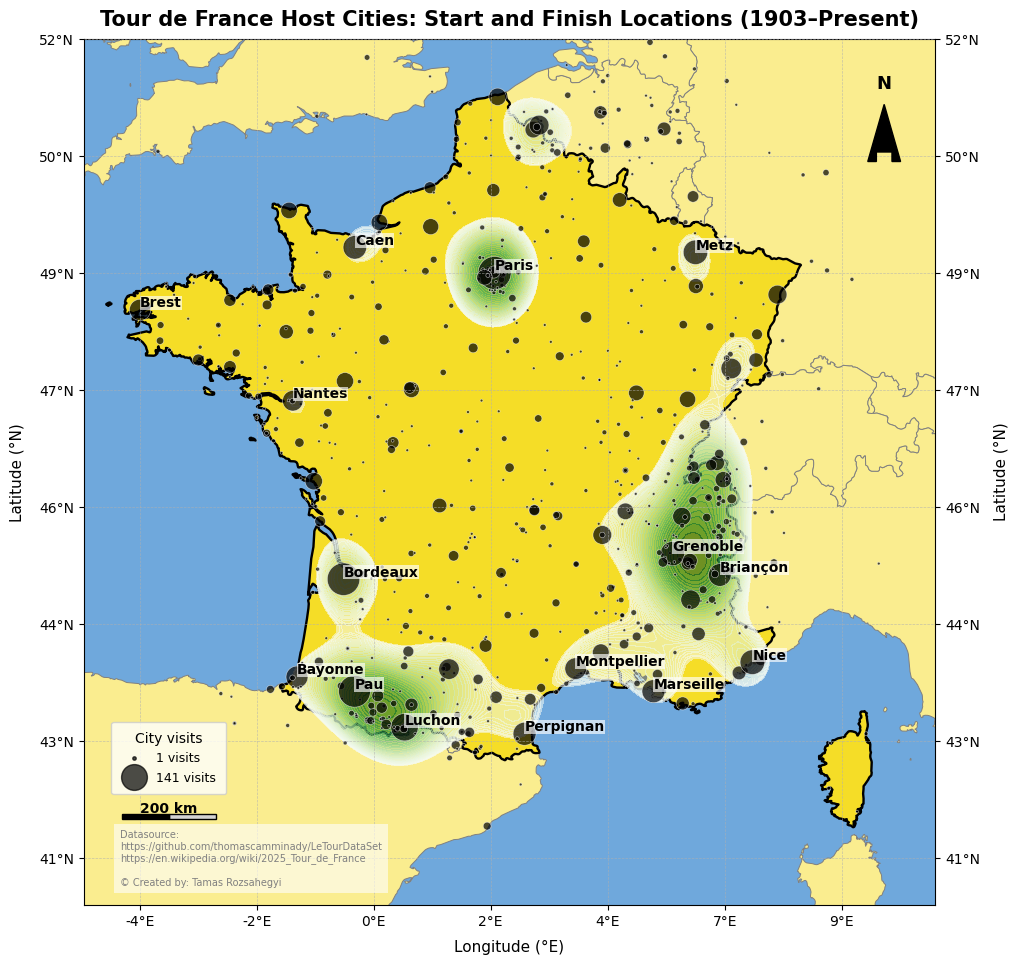

In [22]:
# Plot
plot_tdf_heatmap(df_clean_gdf, top_cities_gdf, world, save_path="Tour_de_France_Heatmap.png")